# CSC2541 - Multiscale Deep Equilibrium Models

This colab notebook has the purpose to explain the functionality of
[MDEQ models](https://arxiv.org/abs/2006.08656) and aid understanding.


References: 


1.   List item
2.   List item






In [1]:
#@title Dependencies and imports
!pip install flax optax

import jax
import jax.numpy as jnp

import jax.lax as lax
from jax import random, jit

import optax

import flax
from flax import linen as nn

from functools import partial

import torchvision

import numpy as np  # TO DO remove np's -> jnp
import contextlib

from typing import Tuple, Union, List, OrderedDict, Callable, Any
from dataclasses import field

# jaxopt has already implicit differentiation!!
import time

from matplotlib import pyplot as plt

# utility function for local random seeding
@contextlib.contextmanager
def np_temp_seed(seed):
	state = np.random.get_state()
	np.random.seed(seed)
	try:
		yield
	finally:
		np.random.set_state(state)


     |████████████████████████████████| 184 kB 4.7 MB/s 
     |████████████████████████████████| 136 kB 35.3 MB/s 
     |████████████████████████████████| 70 kB 5.6 MB/s 
ERROR: Operation cancelled by user


ModuleNotFoundError: ignored

Deep Equilibrium Models - in contrast to conventional neural networks that explicitly build the computational graph during the forward pass - yield an implicit network. 

Within this framework, we consider applying a single layer $f_\theta(z; x)$ repeatedly to the input; then, for a large number of iterations, we assume that there exists a fixed point $z^\star$ so that $$f_\theta(z^\star; x) = z^\star.$$ This $z^\star$ is then equivalent to an infinitely deep NN where $f_\theta$ is applied repeatedly.

At this point we determine $z^\star$ using a (black-box) root finding method, i.e. solving the problem 
$$ g_\theta(z) = f_\theta(z) - z = 0.$$
The trick is then to, instead of building the computational graph for the root-finding method, make use of the implicit function theorem. 

**... bla why this allows us to have O(1) memory usage**

**We will come back to this  later ... when we see the function**



## Root finder
In the following, we define different functions and associated helper functions that are capable of finding $z$ so that, given $\theta$, $g_\theta(z)  = f_\theta(z)-z= 0$. 



*   Newton's method: Solves a root-finding problem by iterating $z^{(i+1)} = z^{(i)} - J_{g_\theta}^{-1} g_\theta(z^{(i)})$.
*   Broyden method: In comparison to Newton's method, the Jacobian is approximated by a finite-difference approximation. 
*   Direct method: Aims to find the steady state by iterating $f_\theta$ multiple times, i.e., $f_\theta(f_\theta(f_\theta(\cdots f_\theta(z))\cdots))\to z^\star$



In [ ]:
#@title Root finding helper functions
def _safe_norm_jax(v):
    if not jnp.all(jnp.isfinite(v)):
        return jnp.inf
    return jnp.linalg.norm(v)

def scalar_search_armijo_jax(phi, phi0, derphi0, c1=1e-4, alpha0=1, amin=0):
    ite = 0
    phi_a0 = phi(alpha0)    # First do an update with step size 1
    if phi_a0 <= phi0 + c1*alpha0*derphi0:
        return alpha0, phi_a0, ite

    # Otherwise, compute the minimizer of a quadratic interpolant
    alpha1 = -(derphi0) * alpha0**2 / 2.0 / (phi_a0 - phi0 - derphi0 * alpha0)
    phi_a1 = phi(alpha1)

    # Otherwise loop with cubic interpolation until we find an alpha which
    # satisfies the first Wolfe condition (since we are backtracking, we will
    # assume that the value of alpha is not too small and satisfies the second
    # condition.
    while alpha1 > amin:       # we are assuming alpha>0 is a descent direction
        factor = alpha0**2 * alpha1**2 * (alpha1-alpha0)
        a = alpha0**2 * (phi_a1 - phi0 - derphi0*alpha1) - \
            alpha1**2 * (phi_a0 - phi0 - derphi0*alpha0)
        a = a / factor
        b = -alpha0**3 * (phi_a1 - phi0 - derphi0*alpha1) + \
            alpha1**3 * (phi_a0 - phi0 - derphi0*alpha0)
        b = b / factor

        alpha2 = (-b + jnp.sqrt(jnp.abs(b**2 - 3 * a * derphi0))) / (3.0*a)
        phi_a2 = phi(alpha2)
        ite += 1

        if (phi_a2 <= phi0 + c1*alpha2*derphi0):
            return alpha2, phi_a2, ite

        if (alpha1 - alpha2) > alpha1 / 2.0 or (1 - alpha2/alpha1) < 0.96:
            alpha2 = alpha1 / 2.0

        alpha0 = alpha1
        alpha1 = alpha2
        phi_a0 = phi_a1
        phi_a1 = phi_a2

    # Failed to find a suitable step length
    return None, phi_a1, ite


def line_search_jax(update, x0, g0, g, nstep=0, on=True):
    """
    `update` is the propsoed direction of update.

    Code adapted from scipy.
    """
    tmp_s = [0]
    tmp_g0 = [g0]
    tmp_phi = [jnp.linalg.norm(g0)**2]
    s_norm = jnp.linalg.norm(x0) / jnp.linalg.norm(update)

    def phi(s, store=True):
        if s == tmp_s[0]:
            return tmp_phi[0]    # If the step size is so small... just return something
        x_est = x0 + s * update
        g0_new = g(x_est)
        phi_new = _safe_norm_jax(g0_new)**2
        if store:
            tmp_s[0] = s
            tmp_g0[0] = g0_new
            tmp_phi[0] = phi_new
        return phi_new
    
    if on:
        s, phi1, ite = scalar_search_armijo_jax(phi, tmp_phi[0], -tmp_phi[0], amin=1e-2)
    if (not on) or s is None:
        s = 1.0
        ite = 0

    x_est = x0 + s * update
    if s == tmp_s[0]:
        g0_new = tmp_g0[0]
    else:
        g0_new = g(x_est)
    return x_est, g0_new, x_est - x0, g0_new - g0, ite

def rmatvec_jax(part_Us, part_VTs, x):
    # Compute x^T(-I + UV^T)
    # x: (N, 2d, L')
    # part_Us: (N, 2d, L', threshold)
    # part_VTs: (N, threshold, 2d, L')
    if jnp.size(part_Us) == 0:
        return -x
    xTU = jnp.einsum('bij, bijd -> bd', x, part_Us)   # (N, threshold)
    return -x + jnp.einsum('bd, bdij -> bij', xTU, part_VTs)    # (N, 2d, L'), but should really be (N, 1, (2d*L'))

def matvec_jax(part_Us, part_VTs, x):
    # Compute (-I + UV^T)x
    # x: (N, 2d, L')
    # part_Us: (N, 2d, L', threshold)
    # part_VTs: (N, threshold, 2d, L')
    if jnp.size(part_Us) == 0:
        return -x
    VTx = jnp.einsum('bdij, bij -> bd', part_VTs, x)  # (N, threshold)
    return -x + jnp.einsum('bijd, bd -> bij', part_Us, VTx)     # (N, 2d, L'), but should really be (N, (2d*L'), 1)


In [ ]:
def broyden_jax(f, z0, x0, threshold, eps=1e-3, stop_mode="rel", result_dict=False, ls=False):
    bsz, total_hsize = z0.shape
    orig_shape = (bsz,total_hsize)
    seq_len = 1
    new_shape = (bsz,total_hsize,seq_len)
    z0 = z0.reshape(*new_shape)
    def g(_z):
        # here it is safe to use x out of scope
        return (f(_z.reshape(*orig_shape),x0)-_z.reshape(*orig_shape)).reshape(*new_shape)
    dev = z0.device()
    alternative_mode = 'rel' if stop_mode == 'abs' else 'abs'
    
    z_est = z0           # (bsz, 2d, L')
    gz = g(z_est)        # (bsz, 2d, L')
    nstep = 0
    tnstep = 0
    
    # For fast calculation of inv_jacobian (approximately)
    Us = jax.device_put(jnp.zeros((bsz, total_hsize, seq_len, threshold)),dev)     # One can also use an L-BFGS scheme to further reduce memory
    VTs = jax.device_put(jnp.zeros((bsz, threshold, total_hsize, seq_len)),dev)
    update = -matvec_jax(Us[:,:,:,:nstep], VTs[:,:nstep], gz)      # Formally should be -torch.matmul(inv_jacobian (-I), gx)
    prot_break = False
    
    # To be used in protective breaks
    protect_thres = (1e6 if stop_mode == "abs" else 1e3) * seq_len
    new_objective = 1e8

    trace_dict = {'abs': [],
                  'rel': []}
    lowest_dict = {'abs': 1e8,
                   'rel': 1e8}
    lowest_step_dict = {'abs': 0,
                        'rel': 0}
    nstep, lowest_zest, lowest_gz = 0, z_est, gz

    while nstep < threshold:
        z_est, gz, delta_z, delta_gz, ite = line_search_jax(update, z_est, gz, g, nstep=nstep, on=ls)
        nstep += 1
        tnstep += (ite+1)
        abs_diff = jnp.linalg.norm(gz)
        rel_diff = abs_diff / (jnp.linalg.norm(gz + z_est) + 1e-9)
        diff_dict = {'abs': abs_diff,
                     'rel': rel_diff}
        trace_dict['abs'].append(abs_diff)
        trace_dict['rel'].append(rel_diff)
        for mode in ['rel', 'abs']:
            if diff_dict[mode] < lowest_dict[mode]:
                if mode == stop_mode: 
                    lowest_zest, lowest_gz = jnp.copy(z_est), jnp.copy(gz)
                lowest_dict[mode] = diff_dict[mode]
                lowest_step_dict[mode] = nstep

        new_objective = diff_dict[stop_mode]
        if new_objective < eps: break
        if new_objective < 3*eps and nstep > 30 and np.max(trace_dict[stop_mode][-30:]) / np.min(trace_dict[stop_mode][-30:]) < 1.3:
            # if there's hardly been any progress in the last 30 steps
            break
        if new_objective > trace_dict[stop_mode][0] * protect_thres:
            prot_break = True
            break

        part_Us, part_VTs = Us[:,:,:,:nstep-1], VTs[:,:nstep-1]
        vT = rmatvec_jax(part_Us, part_VTs, delta_z)
        u = (delta_z - matvec_jax(part_Us, part_VTs, delta_gz)) / jnp.einsum('bij, bij -> b', vT, delta_gz)[:,None,None]
        vT = jnp.nan_to_num(vT,nan=0.)
        u = jnp.nan_to_num(u,nan=0.)
        VTs = VTs.at[:,nstep-1].set(vT)
        Us = Us.at[:,:,:,nstep-1].set(u)
        update = -matvec_jax(Us[:,:,:,:nstep], VTs[:,:nstep], gz)

    # Fill everything up to the threshold length
    for _ in range(threshold+1-len(trace_dict[stop_mode])):
        trace_dict[stop_mode].append(lowest_dict[stop_mode])
        trace_dict[alternative_mode].append(lowest_dict[alternative_mode])

    lowest_zest = lowest_zest.reshape(*orig_shape)
    # print("broyden",jnp.linalg.norm(z_est),jnp.linalg.norm(gz))

    if result_dict:
        return {"result": lowest_zest,
                "lowest": lowest_dict[stop_mode],
                "nstep": lowest_step_dict[stop_mode],
                "prot_break": prot_break,
                "abs_trace": trace_dict['abs'],
                "rel_trace": trace_dict['rel'],
                "eps": eps,
                "threshold": threshold}
    else:
        return lowest_zest


def newton_jax(f, z0, x0, threshold, eps=1e-3):
    # TODO replace with jax while

    # note: f might ignore x0 (i.e. with backward pass)
    orig_shape = z0.shape
    def g(_z):
      # this reshaping is to enable solving with Jacobian
      return (f(_z.reshape(*orig_shape),x0)-_z.reshape(*orig_shape)).reshape(-1)
    jac_g = jax.jacfwd(g)
    z = z0.reshape(-1)
    gz = g(z)
    gz_norm = jnp.linalg.norm(gz)
    nstep = 0

    while nstep < threshold and gz_norm > eps:
      # solve system
      jgz = jac_g(z)
      # print("gz",gz.shape,jnp.linalg.norm(gz))
      # print("jgz",jgz.shape,jnp.linalg.norm(jgz))
      delta_z = jnp.linalg.solve(jgz,-gz)
      # print("delta_z",delta_z.shape,jnp.linalg.norm(delta_z))
      z = z + delta_z
      # need to compute gx here to decide whether to stop
      gz = g(z)
      gz_norm = jnp.linalg.norm(gz)
      nstep += 1

    z = z.reshape(*orig_shape).astype(jnp.float32)

    # assert False

    return z

def direct_jax(f, z0, x0, threshold, eps=1e-3):
    # TODO replace with jax while

    nstep = 0
    z_old = z0
    z_new = f(z0,x0)
    gz = z_new-z_old
    gz_norm = jnp.linalg.norm(gz)
    min_gz_norm, min_z = gz_norm, z_new
    while nstep < threshold and gz_norm > eps:
      z_old = z_new
      z_new = f(z_old,x0)
      gz = z_new-z_old
      gz_norm = jnp.linalg.norm(gz)
      if gz_norm < min_gz_norm:
        min_gz_norm, min_z = gz_norm, z_new
      nstep += 1
    # print("min_gz_norm",min_gz_norm,"nstep",nstep)
    return min_z

## A Multiscale DEQ Model
In order to make DEQ models more applicable to other inputs beyond sequences, such as images, Ref. X introduces the Multiscale DEQ. 

The procedure here, also outlined in the figure below, is the following:


*   We have a set of images that we e.g. want to classify. In our case, we will consider the MNIST data set and aim to classify to which digit the images correspond.
*   In a first step, the images needs to be encoded (`class Encoder`), given my a grid and a corresponding grayscale value.
*   Next, we define the NN layer in a multiscale framework, given by `class MDEQFF`:
 *  Given an input image, `def create_mdeq_inputs` takes this image and reshapes it to different resolutions. We also define reshaping functions that map between a list of resolutions and a long, concatenated vector that is passed into the root-finder.
 * Pass the resolution-wise intermediate values into the residual blocks (`class MDEQBlock`). This consists of the following, at resolution $i$, whereas the input image is re-injected into the highest resolution:
 $$ z_i \gets \text{GroupNorm}(\text{Conv2d}(z_i)) $$
 $$ \hat{z}_i = \text{GroupNorm}(\text{Conv2d}(\text{relu}(z_i))+1_{[i==1]})x) $$
 $$ z^+_i = \text{GroupNorm}(\text{relu}(\hat{z}_i+z_i)) $$
 * Fuse/intertwine the different resolutions by upsampling (calling `class UpSample`, uses bilinear interpolation) and downsampling (calling `class DownSample`, uses a convolutional filter).
* Feed the output of the layer (together with the a function that queries the layer) into the root-finding algorithm. The result of this is a multi-scale representation of the equilibrium state of a theoretically infinitely deep network.  

Note that the parameters of this procedure are on one hand $z$, which is to be determined by a backward pass through the root-finding procedure as well as $\theta$ as the parameters of the `Encoder`, `MDEQBlock`s, the fusing layers and the `Classifier`. 

Thus, in an overall optimization loop, the root-finder determines $z$ so that $g_\theta(z) \approx 0$ given a current set of parameters $\theta$.



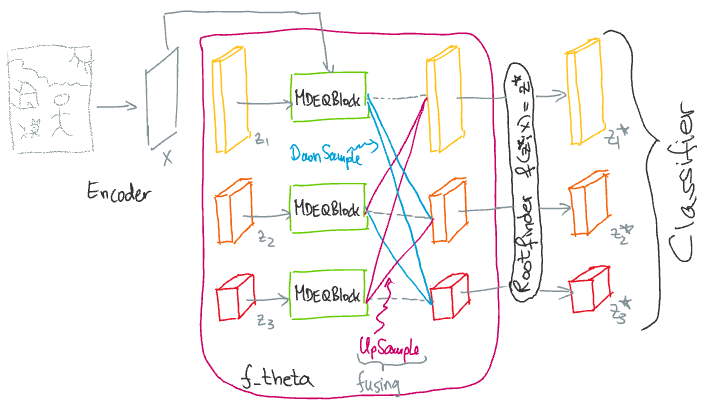

In [ ]:
#@title Reshaping functions
def cringy_reshape(in_vec, shape_list):
    start = 0
    out_vec = []
    if isinstance(in_vec, list):
        raise ValueError
    # in_vec = jnp.array(in_vec)
    for size in shape_list:
        my_elems = jnp.prod(jnp.array(size[1:]))
        end = start+my_elems
        my_chunk = jnp.copy(in_vec[:, start:end])
        start += my_elems
        my_chunk = jnp.reshape(my_chunk, size)
        out_vec.append(my_chunk)

    return out_vec


def create_mdeq_inputs(x, num_branches):

  batch_size = x.shape[0]
  x_list = [x]
  for i in range(1, num_branches):
      bs, H, W, y = x_list[-1].shape
      new_item = jnp.zeros((bs, H//2, W//2, y))
      x_list.append(new_item)
  z_list = [jnp.zeros_like(elem) for elem in x_list]
  shape_list = [el.shape for el in z_list]
  # make them (batched) vectors
  x_vec = jnp.concatenate([x.reshape(batch_size,-1) for x in x_list],axis=1)
  z_vec = jnp.concatenate([z.reshape(batch_size,-1) for z in z_list],axis=1)
  # i'm not sure if tuple is actually important but I like it for non-mutability
  shape_tuple = tuple(shape_list)
  return x_vec, z_vec, shape_tuple

In [ ]:
class Encoder(nn.Module):
    """
    Maps image to initial latent representation
    AKA the grey part in the diagram
    """

    channels: List[int] = field(default_factory=lambda:[24, 24])
    training: bool = True

    def setup(self):
        self.conv1 = nn.Conv(features=self.channels[0], 
                             kernel_size=(3, 3), strides=(1, 1))
        self.bn1 = nn.BatchNorm()
        self.relu = nn.relu

    def __call__(self, x):
        x = self.relu(self.bn1(self.conv1(x), use_running_average=True))
        return x

In [ ]:
class MDEQBlock(nn.Module):
    """

    AKA the green block in the diagram
    """
    curr_branch: int
    channels: List[int]
    kernel_size: Tuple[int] = (3, 3)  # can also be (5, 5), modify later
    num_groups: int = 2
    kernel_init = jax.nn.initializers.glorot_normal()
    bias_init = jax.nn.initializers.glorot_normal()

    
    def setup(self):  
        self.input_dim = self.channels[self.curr_branch]
        self.hidden_dim = 2*self.input_dim

        # init-substitute for flax
        self.conv1 = nn.Conv(features=self.hidden_dim, kernel_size=self.kernel_size,
                             strides=1)#, kernel_init=self.kernel_init, bias_init=self.bias_init)
        self.group1 = nn.GroupNorm(num_groups=self.num_groups)
        self.relu = nn.relu
        self.conv2 = nn.Conv(features=self.input_dim, kernel_size=self.kernel_size,
                             strides=1)#, kernel_init=self.kernel_init, bias_init=self.bias_init)
        self.group2 = nn.GroupNorm(num_groups=self.num_groups)
        self.group3 = nn.GroupNorm(num_groups=self.num_groups)


    def __call__(self, x, branch, injection):
        # forward pass
        h1 = self.group1(self.conv1(x))
        h1 = self.relu(h1)
        h2 = self.conv2(h1)
        
        
        if branch == 0:
            h2 += injection
        
        h2 = self.group2(h2)
        h2 += x
        h3 = self.relu(h2)
        out = self.group3(h3)

        return out

class DownSample(nn.Module):
    channels: List[int]
    branches: Tuple[int]
    num_groups: int
    kernel_init = jax.nn.initializers.glorot_normal()

    def _downsample(self):
        to_res, from_res = self.branches  # sampling from resolution from_res to to_res
        num_samples = to_res - from_res
        assert num_samples > 0

        down_block = []

        for n in range(num_samples):
            inter_chan = self.in_chan if n < num_samples-1 else self.out_chan
            conv_down = nn.Conv(features=inter_chan, kernel_size=(3, 3), strides=(2,2), padding=1, use_bias=False)
                               #, kernel_init=self.kernel_init, use_bias=False)
            group_down = nn.GroupNorm(num_groups=self.num_groups)
                                      #group_size=inter_chan)
            relu_down = nn.relu
            # module_list = [conv_down, group_down]
            if n < num_samples - 1:
                # module = nn.Sequential([conv_down,
                # module = [conv_down, group_down, relu_down]
                down_block += [conv_down, group_down, relu_down]
            else:
                # module = nn.Sequential([conv_down,
                # module = [conv_down, group_down]
                down_block += [conv_down, group_down]
            #down_block.append(module)
        seq = nn.Sequential(down_block)
        return seq

    def setup(self):
        self.in_chan = self.channels[self.branches[0]]
        self.out_chan  = self.channels[self.branches[1]]
        #self.downsample_fn = self._downsample()
        to_res, from_res = self.branches  # sampling from resolution from_res to to_res
        num_samples = to_res - from_res 
        assert num_samples > 0

        down_block = []
        for n in range(num_samples):
            inter_chan = self.in_chan if n < num_samples-1 else self.out_chan
            
            conv_down = nn.Conv(features=inter_chan, kernel_size=(3,3), strides=(2,2), padding=((1,1),(1,1)), use_bias=False)
                               #, kernel_init=self.kernel_init, use_bias=False)
            group_down = nn.GroupNorm(num_groups=self.num_groups)
                                      #group_size=inter_chan)
            relu_down = nn.relu
            # module_list = [conv_down, group_down]
            
            #down_block.append(conv_down)
            #down_block.append(group_down)
                 
            if n < num_samples - 1:
                # module = nn.Sequential([conv_down,
                # module = [conv_down, group_down, relu_down]
                down_block += [conv_down, group_down, relu_down]
            else:
                # module = nn.Sequential([conv_down,
                # module = [conv_down, group_down]
                down_block += [conv_down, group_down]
            
            #down_block.append(module)
            
        self.downsample_fn = nn.Sequential(down_block)
        #self.layers = down_block
        #print('seq', self.layers)

    def __call__(self, z_plus):
        out = self.downsample_fn(z_plus)
        '''
        z = z_plus
        for i, lyr in enumerate(self.layers[:-1]):
            print(i, z.shape)
            z = lyr(z)
            z = nn.relu(z)
            print(i, z.shape)
            #z = nn.sigmoid(z)  # nn.silu(z)  # jnp.tanh(z)  # nn.sigmoid(z)
        out = self.layers[-1](z)
        '''
        return out

class UpSample(nn.Module):
    channels: List[int]
    branches: Tuple[int]
    num_groups: int
    kernel_init = jax.nn.initializers.glorot_normal()

    
    def setup(self):
        self.in_chan = self.channels[self.branches[0]]
        self.out_chan = self.channels[self.branches[1]]
        self.upsample_fn = self._upsample()
        
    ''' the following is from https://github.com/google/jax/issues/862 '''
    
    def interpolate_bilinear(self, im, rows, cols):
        # based on http://stackoverflow.com/a/12729229
        col_lo = np.floor(cols).astype(int)
        col_hi = col_lo + 1
        row_lo = np.floor(rows).astype(int)
        row_hi = row_lo + 1

        nrows, ncols = im.shape[-3:-1]
        def cclip(cols): return np.clip(cols, 0, ncols - 1)
        def rclip(rows): return np.clip(rows, 0, nrows - 1)
        Ia = im[..., rclip(row_lo), cclip(col_lo), :]
        Ib = im[..., rclip(row_hi), cclip(col_lo), :]
        Ic = im[..., rclip(row_lo), cclip(col_hi), :]
        Id = im[..., rclip(row_hi), cclip(col_hi), :]

        wa = np.expand_dims((col_hi - cols) * (row_hi - rows), -1)
        wb = np.expand_dims((col_hi - cols) * (rows - row_lo), -1)
        wc = np.expand_dims((cols - col_lo) * (row_hi - rows), -1)
        wd = np.expand_dims((cols - col_lo) * (rows - row_lo), -1)

        return wa*Ia + wb*Ib + wc*Ic + wd*Id

    def upsampling_wrap(self, resize_rate):
        def upsampling_method(img):
            nrows, ncols = img.shape[-3:-1]
            delta = 0.5/resize_rate

            rows = np.linspace(delta,nrows-delta, np.int32(resize_rate*nrows))
            cols = np.linspace(delta,ncols-delta, np.int32(resize_rate*ncols))
            ROWS, COLS = np.meshgrid(rows,cols,indexing='ij')
        
            img_resize_vec = self.interpolate_bilinear(img, ROWS.flatten(), COLS.flatten())
            img_resize =  img_resize_vec.reshape(img.shape[:-3] + 
                                                (len(rows),len(cols)) + 
                                                img.shape[-1:])
        
            return img_resize
        return upsampling_method
    ''' end copy '''


    def _upsample(self):
        to_res, from_res = self.branches  # sampling from resolution from_res to to_res
        num_samples = from_res - to_res 
        assert num_samples > 0

        return nn.Sequential([nn.Conv(features=self.out_chan, kernel_size=(1, 1), use_bias=False), #kernel_init=self.kernel_init),
                        nn.GroupNorm(num_groups=self.num_groups),
                        self.upsampling_wrap(resize_rate=2**num_samples)])

    def __call__(self, z_plus):
        return self.upsample_fn(z_plus)


In [ ]:
#@title Playing with up-&down sampling
import torch
import torchvision
import jax
import jax.numpy as jnp

import typing

def transform(image, label, num_classes=10):
    image = jnp.float32(image) / 255.
    image = jnp.expand_dims(image, -1)
    # image = np.tile(image, (1,1,1,24))
    label = jnp.array(label)
    return image, label

def load_data():
    test_ds = torchvision.datasets.MNIST(root="data", train=False,download=True)
    train_ds = torchvision.datasets.MNIST(root="data", train=True,download=True)

    train_images, train_labels = transform(train_ds.data, train_ds.targets)
    test_images, test_labels = transform(test_ds.data, test_ds.targets)
    print(f"MUM TRAINING IMAGES:::{train_images.shape[0]}")
    print(f"MUM TEST IMAGES:::{test_images.shape[0]}")

    return train_images, train_labels, test_images, test_labels


''' https://stackoverflow.com/questions/42353676/display-mnist-image-using-matplotlib '''

from matplotlib import pyplot as plt
from jax import image as imx

imgs, _ , _ , _ = load_data()
img = imgs[7]
img = jnp.array(img, dtype='float')
pixels = img.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()


# Upsample 
up = imx.resize(pixels, shape=(56,56), method='bilinear')
plt.imshow(up, cmap='gray')
plt.show()
# Downsample 
up = imx.resize(pixels, shape=(14,14), method='bilinear')
plt.imshow(up, cmap='gray')
plt.show()



In [ ]:
class MDEQFF(nn.Module):
    """
    The f_{\theta}(z,x) function that is repeatedly applied
    AKA the yellow block in the diagram
    """
    num_branches: int
    channels: List[int]
    num_groups: int
    #features: Tuple[int] = (16, 4)
    kernel_init = jax.nn.initializers.glorot_normal()
    
    # branches: List[int] = field(default_factory=lambda:[24, 24, 24])


    #  TODO HERE
    # UnfilteredStackTrace: jax.core.InconclusiveDimensionOperation: Cannot divide evenly the sizes of shapes (64, 32640, 1) and (64, 32, 32, 24)
   

    def setup(self):

        # self.downsample = DownSample(channels=self.channels,
        #                              num_groups=self.num_groups)
        # self.upsample = UpSample(channels=self.channels,
        #                          num_groups=self.num_groups)

        self.branches = self.stack_branches()
        self.fuse_branches = self.fuse()
        self.transform = self.transform_output()

    def stack_branches(self):
        branches = []
        for i in range(self.num_branches):
          branches.append(MDEQBlock(curr_branch=i, channels=self.channels))
        return branches

    def fuse(self):#, z_plus, channel_dimensions):
        # up- and downsampling stuff
        # z_plus: output of residual block
        if self.num_branches == 1:
            return None
        
        fuse_layers = []
        for i in range(self.num_branches):
            array = []
            for j in range(self.num_branches):
                if i == j:
                    # array.append(z_plus[i])
                    array.append(None)
                else:
                    if i > j:
                        sampled = DownSample(branches=(i, j), channels=self.channels, num_groups=self.num_groups)
                        #(z_plus=z_plus, branches=(i, j),
                                                 #channel_dimension=channel_dimensions)
                    elif i < j:
                        sampled = UpSample(branches=(i, j), channels=self.channels, num_groups=self.num_groups)
                        #(z_plus=z_plus, branches=(i, j),
                                                # channel_dimension=channel_dimensions)
                    # array.append(nn.Module(sampled))
                    array.append(sampled)
            # fuse_layers.append(nn.Module(array))
            fuse_layers.append(array)

        return fuse_layers
    
    def transform_output(self):
        transforms = []
        for i in range(self.num_branches):
          transforms.append(nn.Sequential([nn.relu,
                                          nn.Conv(features=self.channels[i], kernel_size=(1, 1),
                                                  #kernel_init=self.kernel_init, 
                                                  use_bias=False),
                                          nn.GroupNorm(num_groups=self.num_groups//2)]))
                                                       #group_size=self.channels[i])]))
        
        return transforms

    def __call__(self, z, x, shape_tuple):
        
        batch_size = z.shape[0]
        z_list = cringy_reshape(z,shape_tuple)
        x_list = cringy_reshape(x,shape_tuple)
        # step 1: compute residual blocks
        branch_outputs = []
        for i in range(self.num_branches):
            branch_outputs.append(self.branches[i](z_list[i], i, x_list[i])) # z, branch, x
        # step 2: fuse residual blocks
        fuse_outputs = []
        for i in range(self.num_branches):
            intermediate_i = jnp.zeros(branch_outputs[i].shape) 
            for j in range(self.num_branches):
                if i == j:
                  intermediate_i += branch_outputs[j]
                else:
                    if self.fuse_branches[i][j] is not None:
                        temp = self.fuse_branches[i][j](z_plus=branch_outputs[j])#, branches=(i, j))
                        intermediate_i += temp
                    else:
                        raise Exception("Should not happen.")
            fuse_outputs.append(self.transform[i](intermediate_i))
          # stick z back into into one vector
        fuse_outputs = jnp.concatenate([fo.reshape(batch_size,-1) for fo in fuse_outputs],axis=1)
        assert fuse_outputs.shape[1] == z.shape[1]
        return fuse_outputs


## Handling output information
As we have seen above, the MDEQ procedure yields a multi-scale representation of the equilibrium state of the MDEQ network. In order to be able to access this information, we add a classifier (`class Classifier`) based on `CLSBlock`s. This outputs the probability of the current image to belong to one of the predefined classes, which in our case (MNIST) are the digits from 0 to 9, and will be used to go into the loss function.

In [ ]:
class CLSBlock(nn.Module):
    """
    A tool for using the 
    """
    input_dim: int
    output_dim: int
    downsample: bool
    expansion: int=4
    
    def setup(self):  


        # init-substitute for flax
        self.conv1 = nn.Conv(features=self.output_dim, kernel_size=(1,1),
                             strides=(1,1))#, kernel_init=self.kernel_init, bias_init=self.bias_init)
        self.bn1 = nn.BatchNorm()
        self.relu = nn.relu
        self.conv2 = nn.Conv(features=self.output_dim, kernel_size=(3,3), strides=(1,1))#, kernel_init=self.kernel_init, bias_init=self.bias_init)
        self.bn2 = nn.BatchNorm()
        self.conv3 = nn.Conv(features=self.output_dim*self.expansion, kernel_size=(1,1), strides=(1,1))#, kernel_init=self.kernel_init, bias_init=self.bias_init)
        self.bn3 = nn.BatchNorm()

        if self.downsample:
            self.ds_conv = nn.Conv(self.output_dim*self.expansion, kernel_size=(1,1), strides=(1,1), use_bias=False)
            self.ds_bn = nn.BatchNorm()


    def __call__(self, x, injection=None):
        # forward pass
        if injection is None:
          injection = 0
        h1 = self.bn1(self.conv1(x), use_running_average=True)
        h1 = self.relu(h1)
        h2 = self.bn2(self.conv2(h1), use_running_average=True)
        h2 = self.relu(h2)
        h3 = self.bn3(self.conv3(h2), use_running_average=True)
        if self.downsample:
          x = self.ds_bn(self.ds_conv(x), use_running_average=True)
        h3 += x
        return nn.relu(h3)

In [ ]:
class Classifier(nn.Module):
    channels: List[int] = field(default_factory=lambda:[24, 24])
    output_channels: List[int] = field(default_factory=lambda:[8, 16])
    expansion: int = 4
    final_chansize: int = 200
    num_classes: int = 10

    def _make_layer(self, inplanes, planes):
          downsample = False
          if inplanes != planes * self.expansion:
              downsample = True
          return CLSBlock(inplanes, planes, downsample)

    def setup(self):
        self.num_branches = len(self.channels)

        incre_modules = []
        for i, channels  in enumerate(self.channels):
            incre_mod = self._make_layer(self.channels[i], self.output_channels[i])
            incre_modules.append(incre_mod)
        self.incre_modules = incre_modules
        downsamp_modules = []
        for i in range(len(self.channels)-1):
            in_channels = self.output_channels[i] * self.expansion
            out_channels = self.output_channels[i+1] * self.expansion
            downsamp_module = nn.Sequential([nn.Conv(out_channels, kernel_size=(3,3), strides=(2,2), use_bias=True),
                                            #nn.BatchNorm(),
                                            nn.relu])
            downsamp_modules.append(downsamp_module)
        self.downsamp_modules = downsamp_modules

        self.final_layer = nn.Sequential([nn.Conv(self.final_chansize, kernel_size=(1,1)),
                                         #nn.BatchNorm(),
                                         nn.relu])
        self.classifier = nn.Dense(self.num_classes)
                                         
    def __call__(self, z_list):
        z = self.incre_modules[0](z_list[0])
        for i in range(len(self.downsamp_modules)):
            z = self.incre_modules[i+1](z_list[i+1]) + self.downsamp_modules[i](z)
        z = self.final_layer(z)
        z = nn.avg_pool(z, window_shape=z.shape[1:3])
        z = jnp.reshape(z, (z.shape[0], -1))
        z = self.classifier(z)
        return z

In [ ]:
#@title Loading MNIST data
def transform(image, label, num_classes=10):
    image = jnp.float32(image) / 255.
    image = np.expand_dims(image, -1)
    # image = np.tile(image, (1,1,1,24))
    label = jnp.array(label)
    return image, label

def load_data():
    test_ds = torchvision.datasets.MNIST(root="data", train=False,download=True)
    train_ds = torchvision.datasets.MNIST(root="data", train=True,download=True)

    train_images, train_labels = transform(train_ds.data, train_ds.targets)
    test_images, test_labels = transform(test_ds.data, test_ds.targets)
    print(f"MUM TRAINING IMAGES:::{train_images.shape[0]}")
    print(f"MUM TEST IMAGES:::{test_images.shape[0]}")

    return train_images, train_labels, test_images, test_labels


## Implicit Differentiation

As we have already hinted before, within training, we will need to backpropagate through the root-finding procedure. However, instead of explicitly differentiating through the specific root-finder, we can treat it implicitly (thanks to the implicit function theorem **PUT A REFERENCE**). 

In `jax`, we can achieve this by setting a custom rule to compute the vector-Jacobian product (`jax.custom_vjp`). This requires a forward call which simply returns the output of the root-finder as well as a backward call that hands over a fixed rule for the `vjp`.

''Implicitly differentiating'' the root-finder allows us to derive the gradient of the loss
$$\frac{\partial \ell}{\partial(\cdot)} = - \frac{\partial \ell}{\partial z^\star}(J^{-1}_{g_\theta}|_{z^\star})\frac{\partial f(z^\star, x)}{\partial (\cdot)},$$
where we need $- \frac{\partial \ell}{\partial z^\star}(J^{-1}_{g_\theta}|_{z^\star})$ to be available from the `custom_vjp` function of the root-find procedure. 

To that end, consider 
$$(J_{g_\theta}^T|_{z^\star})x^T + (\frac{\partial \ell}{\partial z^\star})^T = 0.$$
This can either be treated as linear system giving us the desired expression as $x$ or as a root-finding problem where we can e.g. use the above defined techniques such as the Broyden method. The advantage viewing it as a root-finding problem is that one does not need to explicitly construct the full Jacobian.

In [ ]:
@partial(jax.custom_vjp, nondiff_argnums=(0, 1, 2, 3,)) # nondiff are all except for weights and z/x
def rootfind(solver_fn: Callable,
                 f_fn: Callable,
                 threshold: int,
                 eps: float,
                 weights: dict,
                 z: jnp.ndarray,
                 x: jnp.ndarray):
    f_fn = partial(f_fn, weights)
    return jax.lax.stop_gradient(solver_fn(f_fn, z, x, threshold, eps=1e-3))

# Its forward call (basically just calling it)
def _rootfind_fwd(solver_fn: Callable,
                      f_fn: Callable,
                      threshold: int,
                      eps: float,
                      weights: dict,
                      z: jnp.ndarray,
                      x: jnp.ndarray):
    z = rootfind(solver_fn, f_fn, threshold, eps, weights, z, x)
    return z, (weights, z, x)

# Its backward call (its inputs)
def _rootfind_bwd(solver_fn: Callable,
                      f_fn: Callable,
                      threshold: int,
                      eps: float,
                      res,  
                      grad):
    weights, z, x = res
    (_, vjp_fun) = jax.vjp(f_fn, weights, z, x)
    def z_fn(z, x): # gets transpose Jac w.r.t. weights and z using vjp_fun
        (Jw_T, Jz_T, _) = vjp_fun(z)
        return Jz_T + grad
    z0 = jnp.zeros_like(grad)
    x0 = None # dummy, z_fn does not use x
    ''' potential sanity check -- use a matrix inversion here instead of root-finder ''' 
    g = solver_fn(z_fn, z0, x0, threshold, eps)
    return (None, g, None)

rootfind.defvjp(_rootfind_fwd, _rootfind_bwd)

## Forward pass
In the forward pass, we


*   Encode an image
*   Apply the MDEQ model ($f_\theta=$)
*   Solve for the stationary point ($z^\star=$`rootfind(...)`)



In [ ]:
def mdeq_fn(x,encoder,decoder,deqff,all_weights,solver_fn):
    # TODO move threshold and eps out of this function

    threshold = 7
    eps = 1e-3
    encoder_weights = all_weights["encoder"]
    decoder_weights = all_weights["decoder"]
    deqff_weights = all_weights["mdeqff"]
    batch_size = x.shape[0]
    # transform the input image
    x = encoder.apply(encoder_weights,x)
    # construct inputs (lots of padding and concatenation)
    x, z, shape_tuple = create_mdeq_inputs(x,deqff.num_branches)
    # the root function can only take 3 ndarrays as input
    # this is why it needs the shape_tuple
    def deqff_root(_weights,_z,_x):
      # note: it's safe to pass the shape_tuple here (no tracers)
      return deqff.apply(_weights,_z,_x,shape_tuple)
    # apply rootfinder with custom vjp
    z = rootfind(solver_fn,deqff_root,threshold,eps,deqff_weights,z,x)
    # reshape back to list
    z_list = cringy_reshape(z,shape_tuple)
    log_probs = decoder.apply(decoder_weights,z_list)
    return log_probs

In [ ]:
def cross_entropy_loss(logits, labels):
    ''' 
    should be same as  optax.softmax_cross_entropy(logits, labels); 
    if getting funny results maybe remove log of logits
    '''
    one_hot_labels = jax.nn.one_hot(labels, num_classes=10)
    logits = jax.nn.log_softmax(logits)
    acc = (jnp.argmax(logits, axis=-1) == labels).mean()
    output = -jnp.mean(jnp.sum(one_hot_labels * logits, axis=-1))
    return output, acc

In [ ]:
def train():
    '''
    extra thing: warm-up using gradient descent in pytorch code of official repo
    --> check impact of that and maybe also cost etc (eg if only one layer etc)
    '''

    max_itr = 7 
    print_interval = 5

    train_images, train_labels, test_images, test_labels = load_data()
    num_images = train_images.shape[0]
    image_size = train_images.shape[1]
    batch_size = 64
    assert batch_size <= train_images.shape[0]
    print(num_images,image_size)

    solver_fn = direct_jax

    num_groups = 8
    channels = [24, 24]
    num_branches = 2

    # instantiation
    encoder = Encoder(channels=channels)
    decoder = Classifier() # not sure about what to pass
    mdeqff = MDEQFF(num_branches=num_branches, channels=channels, num_groups=num_groups)

    # weight initialization
    prng = jax.random.PRNGKey(0)
    prng, _ = jax.random.split(prng, 2)
    x_dummy = jnp.ones((batch_size, image_size, image_size, 24))
    print("x_dummy",x_dummy.shape)
    x_dummy_2, encoder_weights = encoder.init_with_output(prng,x_dummy)
    print("x_dummy_2",x_dummy_2.shape)
    x_dummy_3, z_dummy, shape_tuple = create_mdeq_inputs(x_dummy_2,num_branches)
    print("x_dummy_3",x_dummy_3.shape)
    print("z_dummy",z_dummy.shape)
    z_dummy_2, mdeqff_weights = mdeqff.init_with_output(prng,z_dummy,x_dummy_3,shape_tuple)
    print("z_dummy_2", z_dummy_2.shape)
    z_dummy_3 = cringy_reshape(z_dummy_2,shape_tuple)
    # z_dummy_3 is a list
    o_dummy, classifier_weights = decoder.init_with_output(prng,z_dummy_3)
    print("o_dummy", o_dummy.shape)

    # collect weights
    weights = {'encoder': encoder_weights, 'mdeqff': mdeqff_weights ,'decoder': classifier_weights}

    optimizer = optax.adam(learning_rate=0.001)
    opt_state = optimizer.init(weights)

    loss_fn = cross_entropy_loss

    def loss(weights, x_batch, y_true):
        logits = mdeq_fn(x_batch,encoder,decoder,mdeqff,weights,solver_fn)
        return loss_fn(logits, y_true)

    def step(weights, opt_state, x_batch, y_true):
        (loss_vals, acc), grad = jax.value_and_grad(loss, has_aux=True)(weights, x_batch, y_true)
        updates, opt_state = optimizer.update(grad, opt_state, weights)
        weights = optax.apply_updates(weights, updates)

        return weights, opt_state, loss_vals, acc

    def generator(batch_size: int=10):
        ''' https://optax.readthedocs.io/en/latest/meta_learning.html?highlight=generator#meta-learning '''
        rng = jax.random.PRNGKey(0)

        while True:
            rng, k1 = jax.random.split(rng, num=2)
            idxs = jax.random.randint(k1, shape=(batch_size,), minval=0, maxval=num_images, dtype=jnp.int32)
            yield idxs

    def list_shuffler():
        rng = jax.random.PRNGKey(0)
        rng, k1 = jax.random.split(rng, num=2)
        indices = jnp.arange(0, train_images.shape[0])
        shuffled_indices = jax.random.shuffle(k1, indices)
        return shuffled_indices

    max_epoch = 7 
    print_interval = 1

    train_log, val_log = [],[]
    for epoch in range(max_epoch):
        idxs = list_shuffler()
        start, end = 0, 0
        loss_vals = []
        acc_vals = []
        while end < len(idxs):
            end = min(start+batch_size, len(idxs))
            idxs_to_grab = idxs[start:end]
            x_batch = train_images[idxs_to_grab,...]
            x_batch = jnp.tile(x_batch, (1,1,1,24))
            y_true = train_labels[idxs_to_grab]
            start = end
  
            weights, opt_state, batch_loss, batch_acc = step(weights=weights,
                                                 opt_state=opt_state,
                                                 x_batch=x_batch,
                                                 y_true=y_true)
            loss_vals.append(batch_loss)
            acc_vals.append(batch_acc)


            print(f"batch_loss :: {batch_loss} // batch_acc :: {batch_acc}")
            # loss_vals, grads = jax.value_and_grad(loss, has_aux=False)(optimizer.target, x_batch, y_true)
            # optimizer = optimizer.apply_gradient(grads)

        epoch_loss = jnp.average(jnp.array(loss_vals))
        epoch_acc = jnp.average(jnp.array(acc_vals))

        if epoch % print_interval == 0:
            print("\tat epoch", epoch, "have loss", epoch_loss, "and acc", epoch_acc)

        if epoch_loss < 1e-5:
            break

            print('finally', batch_loss) 

Breakdown of code overall:


*   MDEQ modul
*   List item



In [ ]:
train()